In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Sun/ML Shock/Final project/eegClassification

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
freq_eeg = 200 #Hz

In [5]:
# path = '/content/drive/MyDrive/Sun/ML Shock/Final project/eegClassification/'
path = '../'

In [6]:
# all files in path + 'sample_data/train_eegs'
files = os.listdir(path + 'sample_data/train_eegs')
df = pd.read_csv(path + 'sample_data/train.csv')

Check which is the unique identifier in the dataset

In [7]:
for c in df.columns:
    if len(df[c].unique()) == len(df):
        print(c)

label_id


In [8]:
# select rows from df where 'eeg_id' matches the file name, ignoring the 'parquet' extension
df_data = df[df['eeg_id'].isin([int(f.split('.')[0]) for f in files])]


In [9]:
df_data.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')

In [10]:
class_votes = ['seizure_vote', 'lpd_vote','gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
classes = [v.split('_')[0] for v in class_votes]

In [11]:
#  group df data by 'eeg_id' and 'spectrogram_id' and display  'eeg_label_offset_seconds' and 'spectrogram_label_offset_seconds'
df_gr = df_data.groupby(['eeg_id', 'spectrogram_id'])
info = {}
for name, group in df_gr:
    X = group[['eeg_label_offset_seconds', 'spectrogram_label_offset_seconds','expert_consensus','label_id']+class_votes]
    info[name] = X
    print(name)
    print(X)
    print('\n')

(1445780287, 4004824)
    eeg_label_offset_seconds  spectrogram_label_offset_seconds  \
83                       0.0                               0.0   
84                       6.0                               6.0   
85                      16.0                              16.0   

   expert_consensus    label_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
83            Other  3042959589             0         0         0          0   
84            Other   942569566             0         0         0          0   
85            Other  3752799254             0         0         0          0   

    grda_vote  other_vote  
83          0          17  
84          0          17  
85          0          17  


(1572717157, 15428069)
      eeg_label_offset_seconds  spectrogram_label_offset_seconds  \
1288                       0.0                               0.0   
1289                       6.0                               6.0   
1290                      10.0                     

In [12]:
# load parquet files
import pyarrow.parquet as pq

# load parquet files
data = {}
for k in info.keys():
    d = {}
    d['eeg'] = pq.read_table(path + 'sample_data/train_eegs/' +  str(k[0])+'.parquet')
    d['spec'] = pq.read_table(path + 'sample_data/train_spectrograms/' +  str(k[1])+'.parquet')
    d['info'] = info[k]
    data[k] = d


In [13]:
count = 0
for k in data.keys():
    count += len(data[k]['info'])
    X= data[k]['spec']

print('classes:',len(data),' data points:', count)


classes: 6  data points: 69


In [14]:
cols = list(X.to_pandas().columns)
fLL = [c.split('_')[-1] for c in cols if c.split('_')[0] == 'LL']
fLL = [float(f) for f in fLL]
fRL = [c.split('_')[-1] for c in cols if c.split('_')[0] == 'RL'] 
fRL = [float(f) for f in fRL]
fLP = [c.split('_')[-1] for c in cols if c.split('_')[0] == 'LP']
fLP = [float(f) for f in fLP]
fRP = [c.split('_')[-1] for c in cols if c.split('_')[0] == 'RP']
fRP = [float(f) for f in fRP]

In [15]:
fLL == fRL, fLL == fLP, fLL == fRP, fRL == fLP, fRL == fRP, fLP == fRP

(True, True, True, True, True, True)

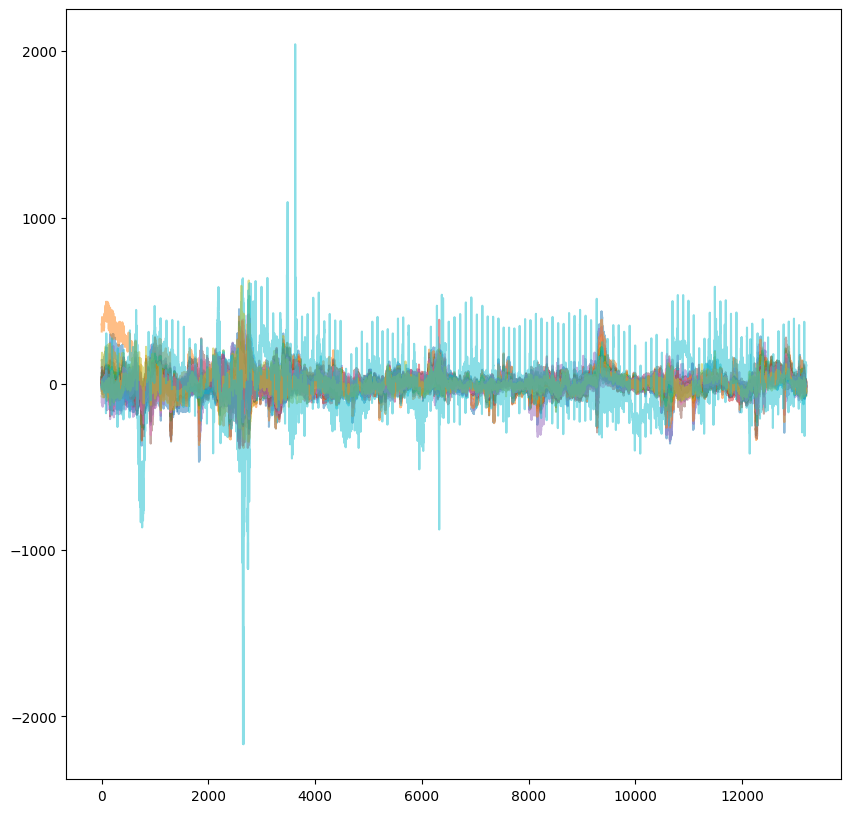

In [16]:
# for data in data plot each column
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plot 10 random columns
k = list(data.keys())[0]
for i in range(20):
    x = data[k]['eeg'].to_pandas()
    ax.plot(x[x.columns[i]], '-', alpha=0.5)
plt.show()

In [17]:
spec_types = ['LL', 'RL', 'LP', 'RP']
# select data from data_spec[0] corresponding to each type
for k in data.keys():
    spec_data = {}
    cols = list(data[k]['spec'].to_pandas().columns)
    spec_data['spec_freq (Hz)'] = np.array([float(c.split('_')[-1]) for c in cols if c.split('_')[0] == 'LL'])
    spec_data['spec_time (s)'] = data[k]['spec'].to_pandas().filter(regex='time').values.reshape(-1)
    
    for spec_type in spec_types:
        spec_data[spec_type] = data[k]['spec'].to_pandas().filter(regex=spec_type).values

    data[k]['spec_sep'] = spec_data


In [18]:
x = data[k]['spec_sep']['LL']
print('LL',x.shape, type(x), x.min(), x.max())

x = data[k]['spec_sep']['spec_time (s)']
print('time (s)',x.shape, type(x), x.min(), x.max(), x.shape)

x = data[k]['spec_sep']['spec_freq (Hz)']
print('freq (Hz)',x.shape, type(x), x.min(), x.max(), x.shape)


LL (312, 100) <class 'numpy.ndarray'> 0.01 366.28
time (s) (312,) <class 'numpy.ndarray'> 1 623 (312,)
freq (Hz) (100,) <class 'numpy.ndarray'> 0.59 19.92 (100,)


In [19]:
for k in data.keys():
    eeg_data = {}
    cols = list(data[k]['eeg'].to_pandas().columns)

    eeg_data['eeg_time (s)'] = np.arange(1, data[k]['eeg'].to_pandas().shape[0]+1)/freq_eeg

    for type in cols:
        eeg_data[type] = data[k]['eeg'].to_pandas()[type].values

    data[k]['eeg_sep'] = eeg_data

In [20]:
x = data[k]['eeg_sep']
# x.keys()
# data[k]['eeg_sep']['Fp1']
data[k]['eeg_sep']['eeg_time (s)']

array([5.0000e-03, 1.0000e-02, 1.5000e-02, ..., 7.3990e+01, 7.3995e+01,
       7.4000e+01])

In [21]:
for k in data.keys():
    print('id:',k)
    print('Spec start & end time (s):', (data[k]['spec_sep']['spec_time (s)'][0], data[k]['spec_sep']['spec_time (s)'][-1]))
    print('eeg length (s):',data[k]['eeg'].to_pandas().shape[0]/freq_eeg)
    print('classifications:', data[k]['info']['expert_consensus'].to_list())
    print('eeg offsets:', data[k]['info']['eeg_label_offset_seconds'].to_list())
    print('spec offsets:', data[k]['info']['spectrogram_label_offset_seconds'].to_list())
    print('label ids:', data[k]['info']['label_id'].to_list())
    print()

id: (1445780287, 4004824)
Spec start & end time (s): (1, 615)
eeg length (s): 66.0
classifications: ['Other', 'Other', 'Other']
eeg offsets: [0.0, 6.0, 16.0]
spec offsets: [0.0, 6.0, 16.0]
label ids: [3042959589, 942569566, 3752799254]

id: (1572717157, 15428069)
Spec start & end time (s): (1, 611)
eeg length (s): 62.0
classifications: ['LPD', 'LPD', 'LPD', 'LPD']
eeg offsets: [0.0, 6.0, 10.0, 12.0]
spec offsets: [0.0, 6.0, 10.0, 12.0]
label ids: [2297156197, 2824053142, 73822170, 2502385693]

id: (2088807520, 198643605)
Spec start & end time (s): (1, 633)
eeg length (s): 84.0
classifications: ['Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure', 'Seizure']
eeg offsets: [0.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 26.0, 28.0, 30.0, 32.0, 34.0]
spec offsets: [0.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 26.0, 28.0, 30.0, 32.0, 34.0]
label ids

In [31]:
data_preprocessed = {}
for k in data.keys():
    votes = data[k]['info'][class_votes].to_numpy()
    votes_list = [votes[i,:] for i in range(votes.shape[0])]
    for kk, offset_eeg, offset_spec, label, v in zip(data[k]['info']['label_id'].to_list(), data[k]['info']['eeg_label_offset_seconds'].to_list(), data[k]['info']['spectrogram_label_offset_seconds'].to_list(), data[k]['info']['expert_consensus'].to_list(), range(len(votes_list))):
        
        d = {}
        
        
        for kkk in data[k]['spec_sep'].keys():
            if kkk == 'spec_freq (Hz)':
                d[kkk] = data[k]['spec_sep'][kkk]
            elif kkk == 'spec_time (s)':
                freq_spec = 1/(data[k]['spec_sep'][kkk][1]-data[k]['spec_sep'][kkk][0])
                start = int((0+offset_spec)*freq_spec)
                end = int((600+offset_spec)*freq_spec)-1
                d[kkk] = data[k]['spec_sep'][kkk][start:end]
            else:
                start = int((0+offset_spec)*freq_spec)
                end = int((600+offset_spec)*freq_spec)-1
                if start >= len(data[k]['spec_sep'][kkk]) or end >= len(data[k]['spec_sep'][kkk]):
                    print('issue spec:', start, end, data[k]['spec_sep'][kkk].shape, data[k]['spec_sep'][kkk][start:end, :].shape)
                else:
                    d['data_spec_'+kkk] = data[k]['spec_sep'][kkk][start:end, :]

        for kkk in data[k]['eeg_sep'].keys():
            start = int((0+offset_eeg)*freq_eeg)
            end = int((49+offset_eeg)*freq_eeg)
            if start >= len(data[k]['eeg_sep'][kkk]) or end >= len(data[k]['eeg_sep'][kkk]):
                print('issue eeg:', start, end, data[k]['eeg_sep'][kkk].shape, data[k]['eeg_sep'][kkk][start:end].shape)
            else:
                if kkk == 'eeg_time (s)':
                    d[kkk] = data[k]['eeg_sep'][kkk][start:end]
                else:
                    d['data_eeg_'+kkk] = data[k]['eeg_sep'][kkk][start:end]

        d['freq'] = (freq_eeg, freq_spec)
        d['class_label'] = label
        d['class_votes'] = votes_list[v]
        d['class_probs'] = votes_list[v]/np.sum(votes_list[v])
        d['classes'] = classes

        del freq_spec

        data_preprocessed[kk] = d


In [32]:
special_keys = ['spec_freq (Hz)', 'spec_time (s)','eeg_time (s)','freq', 'class_label','class_votes','class_probs','classes']

In [33]:
data_preprocessed[kk].keys()

dict_keys(['spec_freq (Hz)', 'spec_time (s)', 'data_spec_LL', 'data_spec_RL', 'data_spec_LP', 'data_spec_RP', 'eeg_time (s)', 'data_eeg_Fp1', 'data_eeg_F3', 'data_eeg_C3', 'data_eeg_P3', 'data_eeg_F7', 'data_eeg_T3', 'data_eeg_T5', 'data_eeg_O1', 'data_eeg_Fz', 'data_eeg_Cz', 'data_eeg_Pz', 'data_eeg_Fp2', 'data_eeg_F4', 'data_eeg_C4', 'data_eeg_P4', 'data_eeg_F8', 'data_eeg_T4', 'data_eeg_T6', 'data_eeg_O2', 'data_eeg_EKG', 'freq', 'class_label', 'class_votes', 'class_probs', 'classes'])

In [28]:
shapes = []
freqs = []
count = 0
for kk in data_preprocessed.keys():
    for k in data_preprocessed[kk].keys():
        if k not in special_keys:
            if data_preprocessed[kk][k].shape not in shapes:
                shapes.append(data_preprocessed[kk][k].shape)
        if data_preprocessed[kk]['freq'] not in freqs:
            freqs.append(data_preprocessed[kk]['freq'])
        
        # try:
        #     print(k, data_preprocessed[kk][k].shape)
        #     #print([s/data_preprocessed[kk]['freq_spec'] for s in data_preprocessed[kk][k].shape], [s/data_preprocessed[kk]['freq_eeg'] for s in data_preprocessed[kk][k].shape])
        # except:
        #     print(k, data_preprocessed[kk][k])         
    # break
    count+=1

In [29]:
9800/200, 299/0.5, shapes, freqs, count

(49.0, 598.0, [(299, 100), (9800,)], [(200, 0.5)], 69)

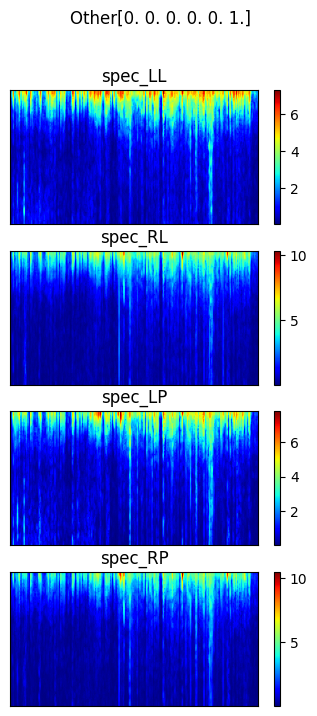

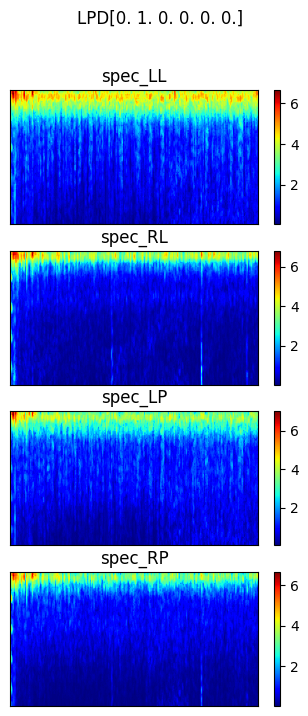

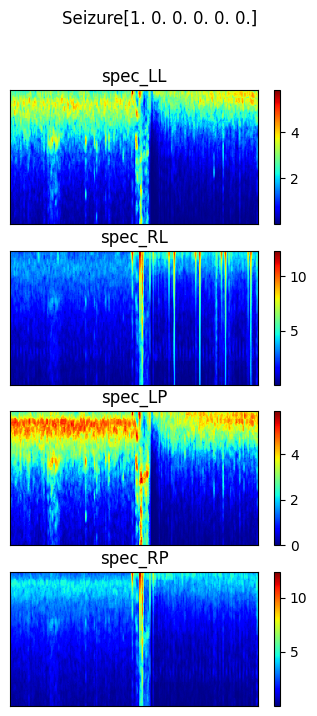

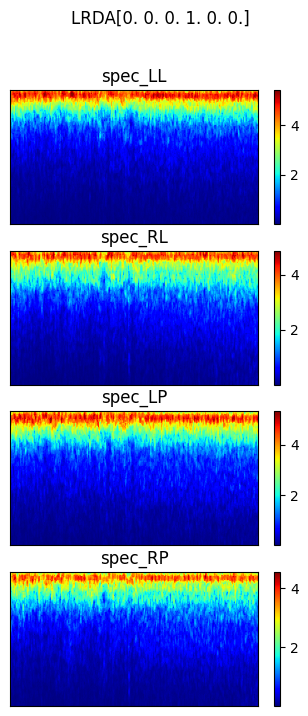

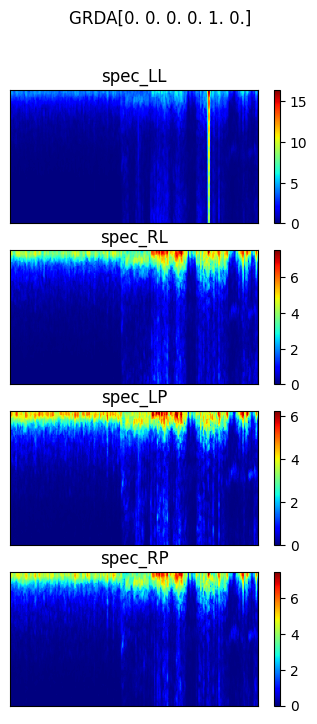

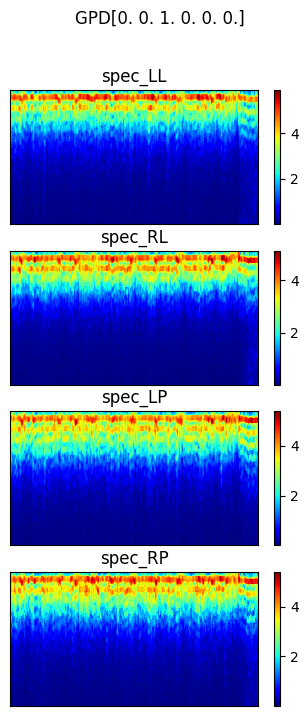

In [30]:
# display spec_types as images

types = []
for kk in data_preprocessed.keys():
    
    if data_preprocessed[kk]['class_label'] not in types:
        types.append(data_preprocessed[kk]['class_label'])
        
        fig, ax = plt.subplots(4,1, figsize=(4,8))
        # title
        fig.suptitle(data_preprocessed[kk]['class_label']+str(data_preprocessed[kk]['class_probs']))
        for i, k in enumerate([ 'data_spec_LL', 'data_spec_RL', 'data_spec_LP', 'data_spec_RP']): 
            X = np.log(data_preprocessed[kk][k].T+1)
            ax[i].imshow(X, aspect='auto', cmap='jet')
            ax[i].set_title(k)
            # set x axis labels to time
            # print(X.shape)
            cbar = plt.colorbar(ax[i].imshow(X, aspect='auto', cmap='jet'), ax=ax[i])
            
            # axese off
            ax[i].set_xticks([])
            ax[i].set_yticks([])
                
        plt.show()
        
    if len(types)==6:
        break


## Work in progress

In [40]:
from scipy.signal import spectrogram

In [41]:
eeg_types = [x for x in data_preprocessed[kk].keys() if 'data_eeg' in x]
len(eeg_types)

20

(129, 43)
0.0 100.0 0.64 47.68


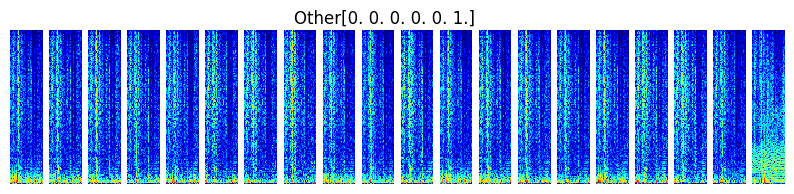

(129, 43)
0.0 100.0 0.64 47.68


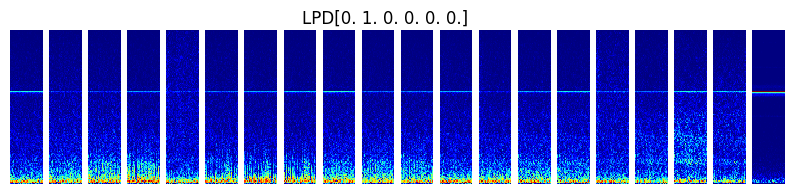

(129, 43)
0.0 100.0 0.64 47.68


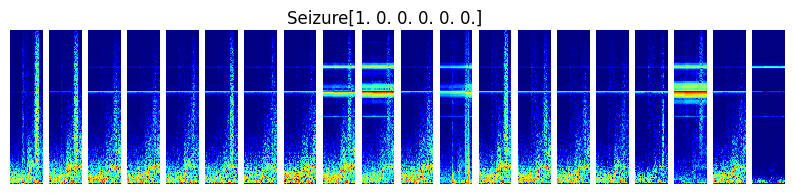

(129, 43)
0.0 100.0 0.64 47.68


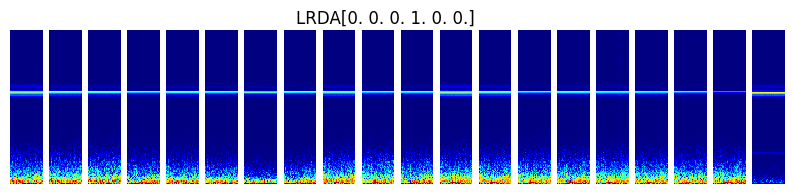

(129, 43)
0.0 100.0 0.64 47.68


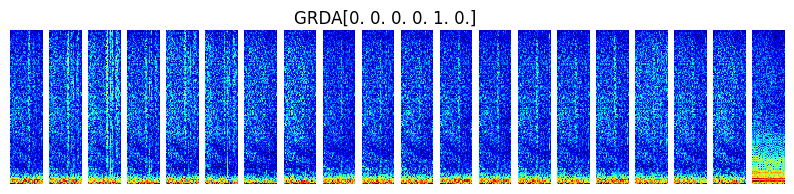

(129, 43)
0.0 100.0 0.64 47.68


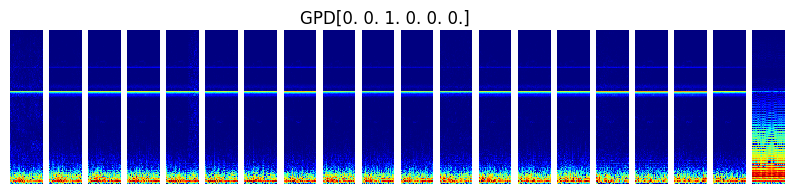

In [44]:
types = []

for kk in data_preprocessed.keys():
    
    if data_preprocessed[kk]['class_label'] not in types:
        types.append(data_preprocessed[kk]['class_label'])
        
        fig, ax = plt.subplots(1,20, figsize=(10, 2))
        # title
        fig.suptitle(data_preprocessed[kk]['class_label']+str(data_preprocessed[kk]['class_probs']))
        for i, k in enumerate(eeg_types): 
            f, t, Sxx = spectrogram(data_preprocessed[kk][k], fs=data_preprocessed[kk]['freq'][0])
            ax[i].pcolormesh(t, f, np.log(Sxx+1), cmap='jet')
            # ax[i].set_title(c)
            # don't show axis
            ax[i].axis('off')
        print(Sxx.shape)
        print(f.min(), f.max(), t.min(), t.max())
                
        plt.show()
        
    if len(types)==6:
        break

In [49]:
for kk in data_preprocessed.keys():
        for i, k in enumerate(eeg_types): 
            f, t, Sxx = spectrogram(data_preprocessed[kk][k], fs=data_preprocessed[kk]['freq'][0])
            data_preprocessed[kk][k+'_spec'] = Sxx
            # print(Sxx.shape)

In [50]:
classes

['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

In [47]:
data_preprocessed[147174724].keys()

dict_keys(['spec_freq (Hz)', 'spec_time (s)', 'data_spec_LL', 'data_spec_RL', 'data_spec_LP', 'data_spec_RP', 'eeg_time (s)', 'data_eeg_Fp1', 'data_eeg_F3', 'data_eeg_C3', 'data_eeg_P3', 'data_eeg_F7', 'data_eeg_T3', 'data_eeg_T5', 'data_eeg_O1', 'data_eeg_Fz', 'data_eeg_Cz', 'data_eeg_Pz', 'data_eeg_Fp2', 'data_eeg_F4', 'data_eeg_C4', 'data_eeg_P4', 'data_eeg_F8', 'data_eeg_T4', 'data_eeg_T6', 'data_eeg_O2', 'data_eeg_EKG', 'freq', 'class_label', 'class_votes', 'class_probs', 'classes', 'data_eeg_Fp1_spec', 'data_eeg_F3_spec', 'data_eeg_C3_spec', 'data_eeg_P3_spec', 'data_eeg_F7_spec', 'data_eeg_T3_spec', 'data_eeg_T5_spec', 'data_eeg_O1_spec', 'data_eeg_Fz_spec', 'data_eeg_Cz_spec', 'data_eeg_Pz_spec', 'data_eeg_Fp2_spec', 'data_eeg_F4_spec', 'data_eeg_C4_spec', 'data_eeg_P4_spec', 'data_eeg_F8_spec', 'data_eeg_T4_spec', 'data_eeg_T6_spec', 'data_eeg_O2_spec', 'data_eeg_EKG_spec'])

## Spectrogram preprocessing

Do min max scaling on all spectrograms (how to deal with new data? - cut off after min max scaling?)
 

Check that eeg_label_offset_seconds == spectrogram_label_offset_seconds for all data


How is the EEG time offset used?
